In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv')

/home/adi/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [53]:
movies_metadata = movies_metadata.dropna(subset=['budget', 'revenue'])
movies_metadata = movies_metadata[movies_metadata['budget'].apply(lambda x: x.isnumeric())]
movies_metadata = movies_metadata.astype({'budget': int, 'revenue':int})

In [54]:
import json

movie_metadata_tmp = movies_metadata.copy()
movie_metadata_tmp["genre"] = np.nan

new_rows = []

for index, movie_metadata in movie_metadata_tmp.iterrows():
    movie_genres_details = json.loads(movie_metadata["genres"].replace('\'', '"'))
    movie_genres = [x["name"] for x in movie_genres_details]
    for movie_genre in movie_genres:
        movie_metadata["genre"] = movie_genre
        new_rows.append(movie_metadata.to_list())

movies_genres = pd.DataFrame(data=new_rows, columns=movie_metadata_tmp.columns)

In [55]:
movies_with_revenue = movies_metadata[movies_metadata['revenue'] > 0]
movies_with_revenue = movies_metadata[movies_metadata['budget'] > 0]
movies_with_revenue = movies_with_revenue.sort_values('budget')

<AxesSubplot:xlabel='budget'>

<Figure size 1440x720 with 0 Axes>

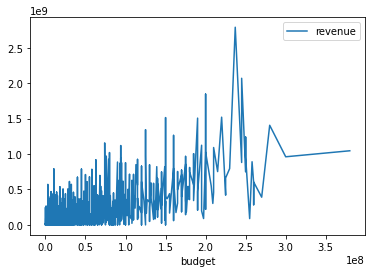

In [74]:
b = movies_with_revenue[["budget", "revenue"]]
b=b.set_index("budget")
plt.figure(figsize=(20, 10))
b.plot()

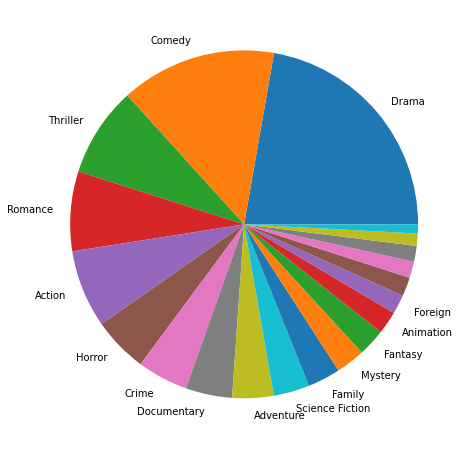

In [66]:
genres_count = movies_genres['genre'].value_counts()
top_genres = genres_count.index.tolist()[:15]
labels = top_genres + [""]*(genres_count.index.size - 15)
plt.figure(figsize=(8, 8))
a = plt.pie(genres_count, labels=labels)

genre
Action      AxesSubplot(0.125,0.125;0.775x0.755)
Comedy      AxesSubplot(0.125,0.125;0.775x0.755)
Drama       AxesSubplot(0.125,0.125;0.775x0.755)
Romance     AxesSubplot(0.125,0.125;0.775x0.755)
Thriller    AxesSubplot(0.125,0.125;0.775x0.755)
Name: revenue, dtype: object

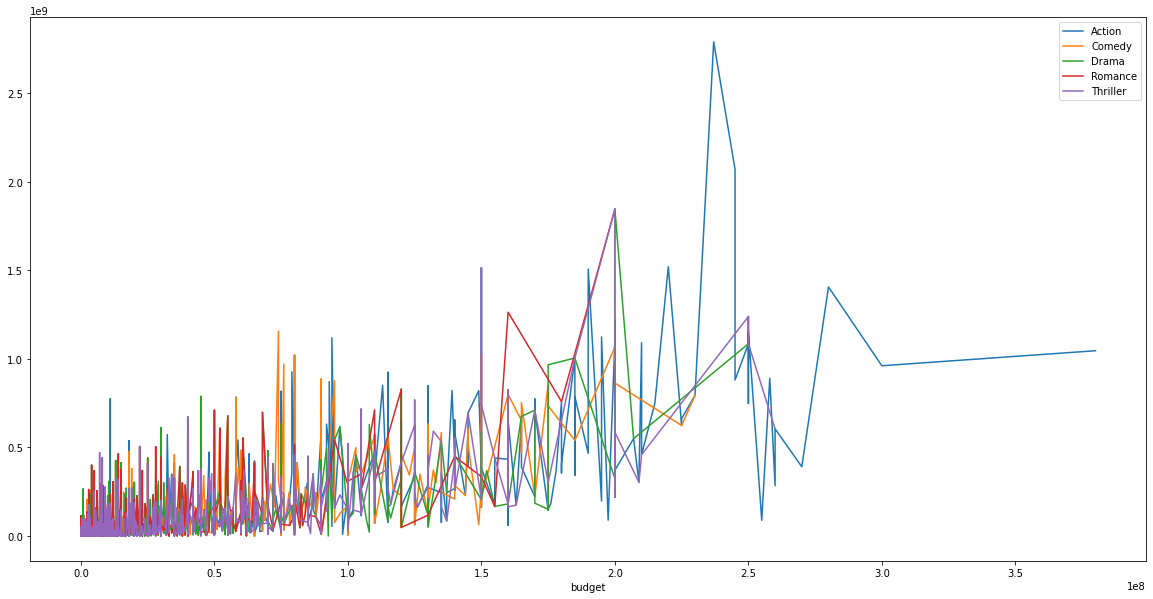

In [75]:
a = movies_genres[['budget', 'revenue', 'genre']]
a = a[a['genre'].isin(top_genres[:5])]
a = a.astype({'budget': int, 'revenue':int}, errors='ignore')
a = a[a['revenue'] > 0]
a = a[a['budget'] > 0]

# a.groupby('genre')
a = a.sort_values('budget')
a.set_index('budget', inplace=True)
plt.figure(figsize=(20, 10))
a.groupby('genre')['revenue'].plot(legend='true')

In [ ]:
import json

movie_metadata_tmp = movies_metadata.copy()
movie_metadata_tmp["genre"] = np.nan

new_rows = []

for index, movie_metadata in movie_metadata_tmp.iterrows():
    movie_genres_details = json.loads(movie_metadata["genres"].replace('\'', '"'))
    movie_genres = [x["name"] for x in movie_genres_details]
    for movie_genre in movie_genres:
        movie_metadata["genre"] = movie_genre
        new_rows.append(movie_metadata.to_list())

c = pd.DataFrame(data=new_rows, columns=movie_metadata_tmp.columns)

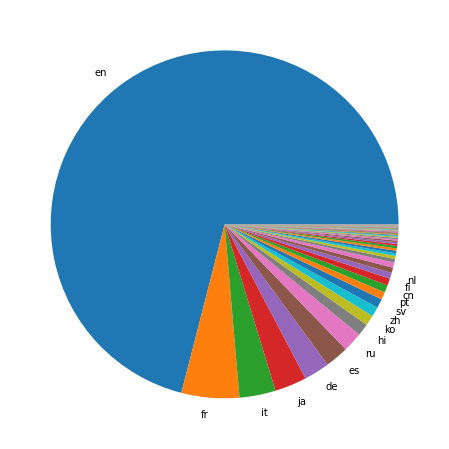

In [82]:
lng_counts = movies_metadata['original_language'].value_counts()

top_lngs = lng_counts.index.tolist()[:15]
labels = top_lngs + [""]*(lng_counts.index.size - 15)
plt.figure(figsize=(8, 8))
a = plt.pie(lng_counts, labels=labels)